<a href="https://colab.research.google.com/github/duyqu-chan/Cat-Dog-Classification/blob/master/CatDogClassification_3_Conv_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat-Dog Classification Homework


In [0]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


First, we will get the raw data from a GitHub[ repo](https://github.com/ardamavi/Dog-Cat-Classifier/tree/master/Data/npy_train_data).

In [0]:
# X:
! wget https://github.com/ardamavi/Dog-Cat-Classifier/blob/master/Data/npy_train_data/X.npy?raw=true -O X.npy
  
# Y:
! wget https://github.com/ardamavi/Dog-Cat-Classifier/blob/master/Data/npy_train_data/Y.npy?raw=true -O Y.npy

--2019-06-19 12:38:29--  https://github.com/ardamavi/Dog-Cat-Classifier/blob/master/Data/npy_train_data/X.npy?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ardamavi/Dog-Cat-Classifier/raw/master/Data/npy_train_data/X.npy [following]
--2019-06-19 12:38:29--  https://github.com/ardamavi/Dog-Cat-Classifier/raw/master/Data/npy_train_data/X.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ardamavi/Dog-Cat-Classifier/master/Data/npy_train_data/X.npy [following]
--2019-06-19 12:38:30--  https://media.githubusercontent.com/media/ardamavi/Dog-Cat-Classifier/master/Data/npy_train_data/X.npy
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.git

Now, we have the following files:

In [0]:
!ls

sample_data  X.npy  Y.npy


We can read the data as follows:

In [0]:
import numpy as np

X = np.load('X.npy')
Y = np.load('Y.npy')

## About the Dataset

There are 1400 images belonging to two classes (cat or dog). The resolution is 64x64 and there are 3 color channels for red, green and blue.

In [0]:
print('X Shape:', X.shape)
print('Y Shape:', Y.shape)

X Shape: (1260, 64, 64, 3)
Y Shape: (1260, 2)


Hopefully, we have uniform categorical distribution.

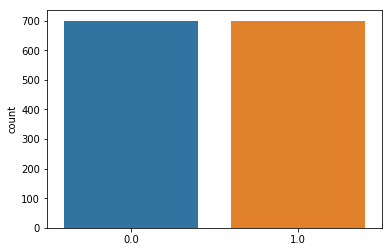

In [0]:
import seaborn as sns
category = Y[:,0]
sns.countplot(category)

Let's visualize 76th sample.

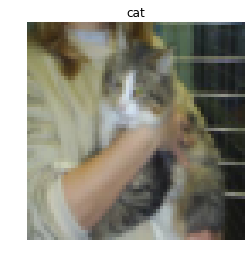

In [0]:
import matplotlib
import matplotlib.pyplot as plt

sample_index = 76
%matplotlib inline
img = X[sample_index]/255 #normalize the image vector into 0-255 range
labelArr = Y[sample_index]

#decode label
if (labelArr == [1, 0]).all():
  label = "cat"
else:
  label = "dog"
  
plt.imshow(img, interpolation='nearest')
plt.axis("off")
plt.title(label)
plt.show()

## Pre-processing
Subtract mean image from each value to center the data around zero

In [0]:
X /= 255
X -= np.mean(X, axis = 0)

## Train/Test Split

We reserved 90% of the data for training and 10% for validation. To better represent test data with training data stratified sampling is used.

In [0]:
from sklearn.model_selection import train_test_split

X, X_test, Y, Y_test = train_test_split(X,Y,test_size = 0.1,stratify=Y, random_state = 42) #random seed i sabitle

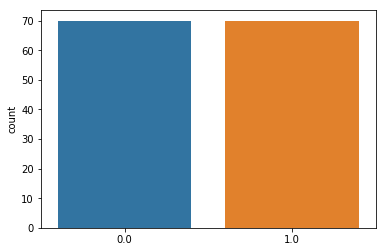

In [0]:
import seaborn as sns
category = Y_test[:,0]
sns.countplot(category)

## Building the Model

### Architecture:
+ Input Data Shape: 64x64x3
+ Layer 1:
  + Convolutional Layer: 32 filters with 5x5 shape
  + Activation Function: Leaky ReLu
  + Max Pooling: with a pooling size of 2x2

+ Layer 2:
  + Convolutional Layer: 64 filters with 3x3 shape
  + Activation Function: Leaky ReLu
  + Max Pooling Pool shape: 2x2

+ Layer 3:
  + Dropout: with rate = 0.25

+ Layer 4: 
  + Convolutional Layer: 128 filters with shape 3x3
  + Activation Function: Leaky ReLu
  + Max Pooling Pool shape: 2x2

+ Classification:
  + Flatten
  + Dense Size: 128
  + Activation Function: ReLu
  + Dropout Rate: 0.35
  + Dense Size: 2
  + Activation Function: Softmax

Optimizer: Adam

Loss: Categorical Crossentropy


In [0]:
# parameters to be optimized
inputShape = (64, 64, 3)
classNum = Y.shape[1]
k1 = 5 # Kernel dimension of the 1st layer
f1 = 32 # the number of output filters in the 1st layer
k2 = 3 # Kernel dimension of the 2nd layer
f2 = 64 # the number of output filters in the 2nd layer
k3 = 3 # Kernel dimension of the 3rd layer
f3 = 128 # the number of output filters in the 3rd layer

d_conv = 0.25 # dropout rate of the convolutional layers
d_dense = 0.35 # dropout rate of the dense layer
LR = 0.0007#learning rate passed to the annealer
Epochs = 40 # 
batchSize = 64 # number of randomly taken samples from features and labels to feed into each epoch until an epoch limit is reached.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  BatchNormalization, Conv2D, MaxPooling2D, Activation
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.layers import LeakyReLU

model = Sequential()

model.add(Conv2D(filters=f1,kernel_size=(k1,k1),padding='Same',kernel_initializer="glorot_normal", 
                 input_shape = inputShape))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
# now add a ReLU layer explicitly:
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(d_conv))


model.add(Conv2D(filters=f2,kernel_size=(k2,k2),padding='Same',kernel_initializer="glorot_normal"))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
# now add a ReLU layer explicitly:
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate =d_conv))



model.add(Conv2D(filters = f3, kernel_size = (k3,k3),padding = 'Same',kernel_initializer="glorot_normal"))
#model.add(BatchNormalization())#kapamayi dene
#model.add(Activation('relu'))
# now add a ReLU layer explicitly:
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(d_conv))
 
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(rate =d_dense))
model.add(Dense(classNum, activation = "softmax")) #sigmoid dene

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 64, 64, 32)        2432      
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 16, 16, 64)        0         
__________

## Compilation

Before training the model, the learning process is needed to be configured. Adam optimizer, which is a combination of Gradient Descent with momentum and RMSProp is chosen because it is effectiveness. Authors of ADAM observed that exponetial averages of past gradients and variance of the gradients (first and secon momentum) decay towars zero, so they come up with a bias correction for these terms. As a cost function categorical cross entropy is chosen since it penalizes bad predictions much more, producing larger gradients and thus converging faster. The cross entropy between estimated probability and target probability will be minimized. LearningRateScheduler can be used to decrease the learning rate by %10 at each epoch as it is in the following


In [0]:
# initiate RMSprop optimizer

#opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1e-2)
#opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#opt = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#opt =keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
opt = keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = keras.optimizers.Adamax(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0)
#opt = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt, #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: LR * 0.9 ** x)

## Data Augmentation

To make model more robust, the data set is expanded with ImageDataGenerator. Noise added, images are distorted by shifting, rotating and flipping. Thes transformations are done because change in the perpective can change the apparent shape of the animals

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

print(X.shape)
datagen.fit(X)
print(X.shape)

(1260, 64, 64, 3)
(1260, 64, 64, 3)


## Training

As it is seen from the final epoch, training accuracy is smaller than validation accuracy. This is due to dropout regulizer. Training accuracy is calculated with the network where some units are dropped randomly but validation accuracy is calculated using whole network. When we evaluate the model on the training set, we see that the performance score is increased since the regularization layers are turned-off during the evaluation. 

In [0]:
# Fit the model
history = model.fit_generator(datagen.flow(X,Y, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,Y_test),
                              verbose = 1, steps_per_epoch=X.shape[0] // batchSize
                              , callbacks=[annealer])

Epoch 1/40
19/19 [==============================] - 5s 242ms/step - loss: 0.7032 - acc: 0.5263 - val_loss: 0.6878 - val_acc: 0.5500
Epoch 2/40
19/19 [==============================] - 1s 52ms/step - loss: 0.6769 - acc: 0.5811 - val_loss: 0.6749 - val_acc: 0.6000
Epoch 3/40
19/19 [==============================] - 1s 68ms/step - loss: 0.6498 - acc: 0.6406 - val_loss: 0.7704 - val_acc: 0.5357
Epoch 4/40
19/19 [==============================] - 1s 68ms/step - loss: 0.6359 - acc: 0.6462 - val_loss: 0.6502 - val_acc: 0.6286
Epoch 5/40
19/19 [==============================] - 1s 69ms/step - loss: 0.6310 - acc: 0.6476 - val_loss: 0.6508 - val_acc: 0.6429
Epoch 6/40
19/19 [==============================] - 1s 70ms/step - loss: 0.6117 - acc: 0.6752 - val_loss: 0.6057 - val_acc: 0.7143
Epoch 7/40
19/19 [==============================] - 1s 70ms/step - loss: 0.6127 - acc: 0.6687 - val_loss: 0.6250 - val_acc: 0.6571
Epoch 8/40
19/19 [==============================] - 1s 70ms/step - loss: 0.5937 - 

## Training and Validation Performance

In [0]:
valLoss, valAcc = model.evaluate(X_test, Y_test, verbose=0)
trainLoss, trainAcc = model.evaluate(X, Y, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

Validation Loss: 0.534539, Validation Accuracy: 0.707143
Train Loss: 0.469002, Train Accuracy: 0.783333


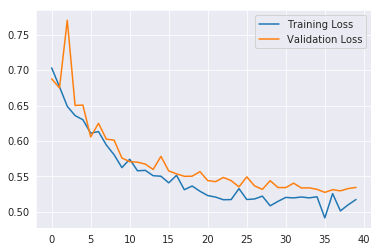

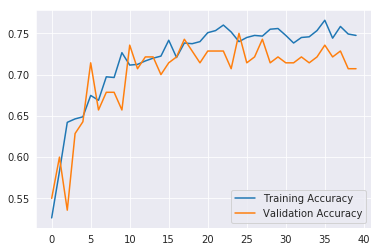

In [0]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

## Confusion Matrix

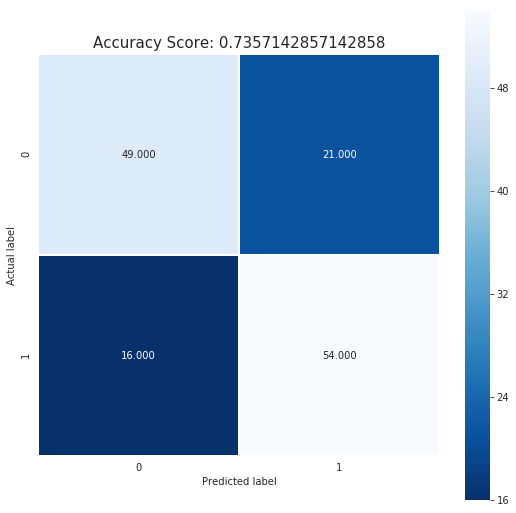

In [0]:
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test) # Predict values of the test set
testLoss, testAcc = model.evaluate(X_test, Y_test, verbose=0)
pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test = to_categorical(Y_test, num_classes = classNum) 
y_test1hot = np.argmax(Y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix
#print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


testLoss, testAcc = model.evaluate(X_test, Y_test, verbose=0)

all_sample_title = 'Accuracy Score: {0}'.format(testAcc)
plt.title(all_sample_title, size = 15);

## Saving the model

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model3.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
model.save("model_3rdBest.h5")

## Let's Try!

--2019-06-19 13:19:47--  https://img-s2.onedio.com/id-553a2f679b938449229cee67/rev-0/raw/s-50cdc6132cfa31fb3a0a43263997af4e2fb0c8b5.jpg
Resolving img-s2.onedio.com (img-s2.onedio.com)... 104.16.228.51, 104.16.229.51, 2606:4700::6810:e533, ...
Connecting to img-s2.onedio.com (img-s2.onedio.com)|104.16.228.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30196 (29K) [image/jpeg]
Saving to: ‘test_img.jpg’

test_img.jpg        100%[===================>]  29.49K  --.-KB/s    in 0s      

2019-06-19 13:19:47 (106 MB/s) - ‘test_img.jpg’ saved [30196/30196]

model2.h5	  model.json   test_img.jpg  Y.npy
model_2ndBest.h5  sample_data  X.npy
Olasılıklar: [0.70508575 0.2949143 ]
It is a cat !


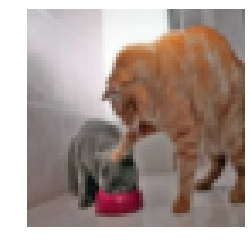

In [0]:
!wget https://img-s2.onedio.com/id-553a2f679b938449229cee67/rev-0/raw/s-50cdc6132cfa31fb3a0a43263997af4e2fb0c8b5.jpg -O test_img.jpg
!ls

from skimage.io import imread
from skimage.transform import resize
from io import StringIO
# TODO: Görüntüyü okuyalım:
# TODO: Görüntüyü yeniden boyutlandıralım:
# TODO: Görüntüyü Numpy Array haline getirip batch axis ekleyelim.
img_size = 64
img = imread("test_img.jpg")
img = resize(img, (img_size, img_size, 3))
X_test2 = np.zeros((1, 64, 64, 3), dtype='float64')
X_test2[0] = img
X_test2 /= 255
X_test2 -= np.mean(X_test, axis = 0)
# TODO: Görüntüyü ekranda gösterelim:
plt.imshow(img, interpolation='nearest')

plt.axis("off")

#plt.show()
# Model çıktısını alalım:
Y_test_img = model.predict(X_test2)
print('Olasılıklar:', Y_test_img[0])
Y_test_img = np.argmax(Y_test_img, axis=1)
Y_test_img = 'cat' if Y_test_img[0] == 0 else 'dog'
print('It is a '+ Y_test_img + ' !')